In [1]:
#|default_exp app_v1

## Reimplementing DiffEdit

In this notebook we're going to reimplement the semantic image editing process illustrated in the [DiffEdit](https://arxiv.org/abs/2210.11427) paper. In the paper, the authors proposed using text input to create a mask of the queried object, and essentially using an img2img type of processing, such that changes could be made to the object without making changes to the context of the image. 

## Example

<center><img alt="DiffEdit Workflow" width="1000" src="imgs/diffusion_method2.jpg" /></center>

### Imports

In [2]:
#| export
import torch
from transformers import CLIPTextModel, CLIPTokenizer
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import PIL
from IPython.display import display
import tsensor
from lolviz import *

import matplotlib as mpl
import logging

plt.rcParams["figure.figsize"] = (6,6)
plt.rcParams["figure.dpi"] = 288

logging.getLogger("matplotlib.font_manager").setLevel(logging.ERROR)
logging.disable(logging.WARNING)
torch.manual_seed(1);

### CLIP Tokenizer and Text Encoder

In [3]:
#| export
tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-large-patch14", torch_dtype=torch.float16)
text_encoder = CLIPTextModel.from_pretrained("openai/clip-vit-large-patch14", torch_dtype=torch.float16).to("cuda")

### VAE and UNET

In [4]:
#| export
from diffusers import AutoencoderKL, UNet2DConditionModel

In [5]:
#| export
vae = AutoencoderKL.from_pretrained("stabilityai/sd-vae-ft-ema", torch_dtype=torch.float16).to("cuda")
unet = UNet2DConditionModel.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="unet", torch_dtype=torch.float16).to("cuda")

### Import Image

In [10]:
#| export
im = PIL.Image.open('imgs/IMG_4104_512.jpg')

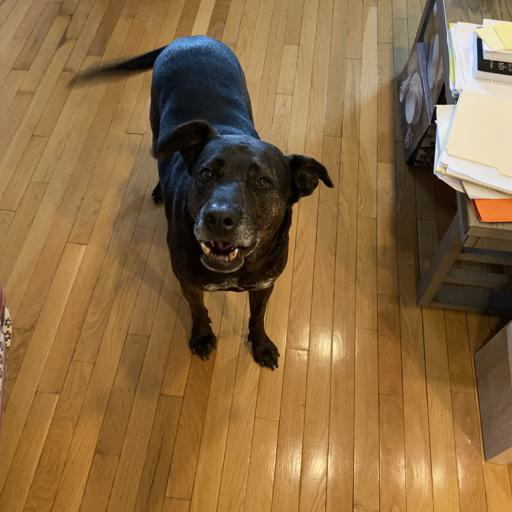

In [11]:
im

### Convert Image to Latent

In [15]:
from torchvision.transforms import Compose, Resize, ToTensor, Normalize

In [16]:
preprocess = Compose([
    Resize((512,512)), #Resize to match VAE input size
    ToTensor(),        #Convert to tensor
    # Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))    # Normalize img tensor to range [-1,1]
])

In [17]:
?Normalize

Init signature: Normalize(mean, std, inplace=False)
Docstring:     
Normalize a tensor image with mean and standard deviation.
This transform does not support PIL Image.
Given mean: ``(mean[1],...,mean[n])`` and std: ``(std[1],..,std[n])`` for ``n``
channels, this transform will normalize each channel of the input
``torch.*Tensor`` i.e.,
``output[channel] = (input[channel] - mean[channel]) / std[channel]``

.. note::
    This transform acts out of place, i.e., it does not mutate the input tensor.

Args:
    mean (sequence): Sequence of means for each channel.
    std (sequence): Sequence of standard deviations for each channel.
    inplace(bool,optional): Bool to make this operation in-place.
Init docstring: Initializes internal Module state, shared by both nn.Module and ScriptModule.
File:           ~/mambaforge/envs/fastai/lib/python3.10/site-packages/torchvision/transforms/transforms.py
Type:           type
Subclasses:     

In [18]:
im_tensor = preprocess(im).unsqueeze(0).to("cuda").half()

In [19]:
im_tensor.shape

torch.Size([1, 3, 512, 512])

In [20]:
im_tensor[0].shape

torch.Size([3, 512, 512])

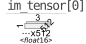

In [21]:
with tsensor.explain():
    im_tensor[0]

In [22]:
with torch.no_grad():
    im_latent = vae.encode(im_tensor)

In [23]:
im_latent_sample = im_latent.latent_dist.sample()

In [24]:
with torch.no_grad():
    image = vae.decode(im_latent_sample).sample

In [25]:
image = image.clamp(0,1)

In [26]:
image.shape

torch.Size([1, 3, 512, 512])

In [27]:
image = image[0].detach().cpu().permute(1,2,0).numpy()

In [28]:
image = (image * 255).round().astype("uint8")

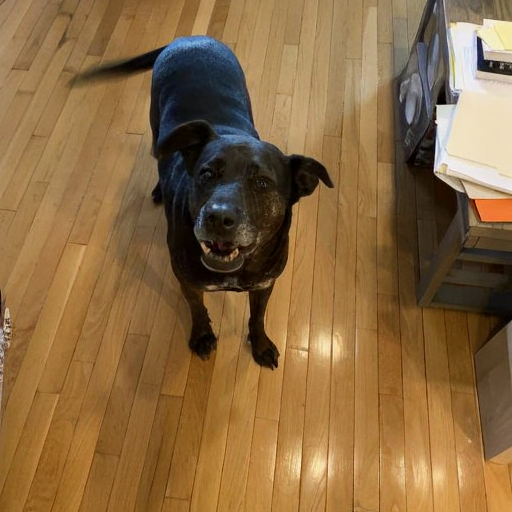

In [29]:
PIL.Image.fromarray(image)

In [ ]:
import nbdev
nbdev.export.nb_export('diffedit.ipynb', 'app_v1')
print("export successful")

### Scheduling

In [6]:
#| export
from diffusers import LMSDiscreteScheduler

In [7]:
scheduler = LMSDiscreteScheduler(num_train_timesteps=1000, beta_start=0.00085, beta_end=0.012, beta_schedule="scaled_linear")

### Parameters for Generation

In [8]:
#| export
q = ["dog"]
r = ["cat"]

height = 512
width = 512
num_inference_steps = 70
guidance_scale = 7.5
batch_size = 1

### Tokenize the text

In [9]:
#| export
q_input = tokenizer(
    q, padding="max_length", max_length=tokenizer.model_max_length, 
    truncation=True, return_tensors="pt"
)
r_input = tokenizer(
    r, padding="max_length", max_length=tokenizer.model_max_length, 
    truncation=True, return_tensors="pt"
)

### Create Noise and Add Scheduler

In [12]:
#| export
torch.manual_seed(255)

latents = torch.randn((batch_size, unet.in_channels, height // 8, width //8))
latents = latents.to("cuda").half()
latents.shape

torch.Size([1, 4, 64, 64])

In [13]:
#| export
scheduler.set_timesteps(num_inference_steps)

In [14]:
#| export
latents = latents * scheduler.init_noise_sigma